In [1]:
from time import time, process_time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from utility import *

homedir = get_homedir()

In [2]:
FIPS_mapping, FIPS_full = get_FIPS(reduced=True)

## Load Datasets

In [3]:
berkeley = pd.read_csv(f"{homedir}/data/us/aggregate_berkeley.csv", index_col=0)
berkeley['countyFIPS'] = berkeley['countyFIPS'].apply(correct_FIPS)
berkeley = fix_FIPS(berkeley, fipslabel='countyFIPS', reduced=True)
berkeley.head()

,countyFIPS,PopulationEstimate2018,Population(Persons)2017,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,...,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated
0,01001,55601.0,55504.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,...,0.0,0.0,10.0,20.0,44.0,73.0,112.0,143.0,109.0,33.194755
1,01003,218022.0,212628.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,...,0.0,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,148.887537
2,01005,24881.0,25270.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,...,0.0,0.0,0.0,0.0,21.0,44.0,65.0,72.0,68.0,18.483155
3,01007,22400.0,22668.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,...,0.0,0.0,0.0,0.0,24.0,37.0,62.0,56.0,45.0,15.381366
4,01009,57840.0,58013.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,...,0.0,10.0,13.0,25.0,49.0,94.0,150.0,182.0,142.0,48.499442


In [4]:
popularity_type= ['PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
       'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
       'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
       'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
       'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
       'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
       'PopMale>842010', 'PopFmle>842010']
popularity_type_Male = popularity_type[::2]
popularity_type_Fmle = popularity_type[1::2]
motality_type = ['3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17',
       '3-YrMortalityAge15-24Years2015-17',
       '3-YrMortalityAge25-34Years2015-17',
       '3-YrMortalityAge35-44Years2015-17',
       '3-YrMortalityAge45-54Years2015-17',
       '3-YrMortalityAge55-64Years2015-17',
       '3-YrMortalityAge65-74Years2015-17',
       '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17']

In [5]:
kNNdata = pd.DataFrame()
kNNdata['fips'] = berkeley['countyFIPS']
kNNdata['PopRatioMale2017'] = berkeley['PopTotalMale2017'] / (berkeley['PopTotalMale2017']+berkeley['PopTotalFemale2017'])
kNNdata['PopRatio65+2017'] = berkeley['PopulationEstimate65+2017'] / (berkeley['PopTotalMale2017']+berkeley['PopTotalFemale2017'])
kNNdata['PopulationDensityperSqMile2010'] = berkeley['PopulationDensityperSqMile2010']
kNNdata['MedicareEnrollment,AgedTot2017'] = berkeley['MedicareEnrollment,AgedTot2017'] / (berkeley['PopTotalMale2017']+berkeley['PopTotalFemale2017'])
kNNdata['#Hospitals'] = 20000 * berkeley['#Hospitals'] / (berkeley['PopTotalMale2017']+berkeley['PopTotalFemale2017'])
kNNdata['#ICU_beds'] = 10000 * berkeley['#ICU_beds'] / (berkeley['PopTotalMale2017']+berkeley['PopTotalFemale2017'])
for i in range(len(popularity_type_Male)):
    kNNdata['PopRatio'+popularity_type_Male[i][3:]] = berkeley[popularity_type_Male[i]] / (berkeley[popularity_type_Male[i]]+berkeley[popularity_type_Fmle[i]])
    kNNdata['PopRatio'+popularity_type_Male[i][7:]] = berkeley[popularity_type_Male[i]] / (berkeley['PopTotalMale2017']+berkeley['PopTotalFemale2017'])
kNNdata['HeartDiseaseMortality'] = berkeley['HeartDiseaseMortality']
kNNdata['StrokeMortality'] = berkeley['StrokeMortality']
kNNdata['DiabetesPercentage'] = berkeley['DiabetesPercentage']
kNNdata['Smokers_Percentage'] = berkeley['Smokers_Percentage']

kNNdata.fillna(0, inplace=True)

kNNdata.head()

,fips,PopRatioMale2017,PopRatio65+2017,PopulationDensityperSqMile2010,"MedicareEnrollment,AgedTot2017",#Hospitals,#ICU_beds,PopRatioMale<52010,PopRatio<52010,PopRatioMale5-92010,...,PopRatioMale65-742010,PopRatio65-742010,PopRatioMale75-842010,PopRatio75-842010,PopRatioMale>842010,PopRatio>842010,HeartDiseaseMortality,StrokeMortality,DiabetesPercentage,Smokers_Percentage
0,01001,0.486578,0.151196,91.8,0.144963,0.360334,1.081003,0.521375,0.033619,0.501378,...,0.453775,0.032808,0.424319,0.015152,0.288566,0.002865,204.5,56.1,9.9,18.081557
1,01003,0.485472,0.199470,114.7,0.195600,0.282183,2.398555,0.503137,0.026403,0.502802,...,0.480705,0.040249,0.459400,0.020595,0.363749,0.005531,183.2,41.9,8.5,17.489033
2,01005,0.527701,0.188247,31.0,0.186229,0.791452,1.978631,0.497650,0.033518,0.503045,...,0.476765,0.042224,0.405537,0.019707,0.291196,0.005105,220.4,49.0,15.7,21.999985
3,01007,0.535469,0.160226,36.8,0.149506,0.882301,0.000000,0.516691,0.031410,0.540214,...,0.466048,0.035424,0.409292,0.016323,0.261649,0.003220,225.5,57.2,13.3,19.114200
4,01009,0.493114,0.178426,88.9,0.164480,0.344750,1.034251,0.499170,0.031114,0.498969,...,0.470762,0.041215,0.431818,0.018996,0.289604,0.004034,224.8,52.8,14.9,19.208672


In [6]:
deaths = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties.csv", parse_dates=['date'])
deaths.dropna(inplace=True)
deaths['fips'] = deaths['fips'].apply(correct_FIPS)
# deaths.drop(columns=['county', 'state', 'cases'], inplace=True)
deaths = fix_FIPS(deaths, fipslabel='fips', datelabel='date', reduced=True)
deaths.head()

,date,fips,cases,deaths
0,2020-01-21,53061,1,0
1,2020-01-22,53061,1,0
2,2020-01-23,53061,1,0
3,2020-01-24,17031,1,0
4,2020-01-24,53061,1,0


In [7]:
mobility = pd.read_csv(f'{homedir}/data/us/mobility/DL-us-mobility-daterow.csv', parse_dates=['date'])
mobility.dropna(subset=['fips'], inplace=True)
mobility['fips'] = mobility['fips'].apply(correct_FIPS)
mobility.drop(columns=['admin_level', 'samples'], inplace=True)
mobility = fix_FIPS(mobility, fipslabel='fips', datelabel='date', reduced=True)
mobility.head()

,date,fips,m50,m50_index
0,2020-03-01,01001,7.194,49
1,2020-03-01,01003,9.780,81
2,2020-03-01,01005,8.348,90
3,2020-03-01,01007,13.008,53
4,2020-03-01,01009,15.963,68


In [8]:
FIPS_demo = set(kNNdata['fips']); FIPS_mt = set(deaths['fips']); FIPS_mb = set(mobility['fips'])
print(len(FIPS_demo), len(FIPS_mt), len(FIPS_mb))

3114 2868 2721


In [9]:
date_st_mt = deaths['date'].min(); date_ed_mt = deaths['date'].max()
date_st_mb = mobility['date'].min(); date_ed_mb = mobility['date'].max()
print(date_st_mt, date_st_mb, date_ed_mt, date_ed_mb)

2020-01-21 00:00:00 2020-03-01 00:00:00 2020-05-03 00:00:00 2020-05-01 00:00:00


In [10]:
"""
Filling in missing dates by searching closest date of the same day.
"""
oneweek = pd.Timedelta(days=7)
ndays = (date_ed_mb - date_st_mb).days+1
dwin = pd.date_range(start=date_st_mb, end=date_ed_mb)
altrange = [item for sublist in [[n,-n] for n in range(1, ndays//7+1)] for item in sublist]
m50toAdd = []
for fips in FIPS_mb:
    df = mobility[mobility['fips']==fips]
    if len(df) != ndays:
        existingdates = list(df['date'])
        missingdates = set(dwin).difference(set(existingdates))
        for dt in missingdates:
            samedays = [dt + n*oneweek for n in altrange if (dt + n*oneweek) in existingdates]
            if samedays:
                m50, m50_index = df[df['date']==samedays[0]]['m50'].iloc[0], df[df['date']==samedays[0]]['m50_index'].iloc[0]
            else:
                m50, m50_index = df[df['date']==existingdates[-1]]['m50'].iloc[0], df[df['date']==existingdates[-1]]['m50_index'].iloc[0]
            m50toAdd.append([dt, fips, m50, m50_index])
mobility = mobility.append(pd.DataFrame(m50toAdd, columns=mobility.columns))
mobility[['date', 'fips']].duplicated().sum()

0

In [11]:
"""
Filling in missing counties using their state.
"""
for fips in FIPS_demo.difference(FIPS_mb):
    stt = str(int(fips[:2]))
    if stt in FIPS_mb:
        dummy = mobility[mobility['fips']==stt]
        dummy['fips'] = fips
        mobility = mobility.append(dummy)

In [12]:
FIPS_mb = set(mobility['fips'])
print(len(FIPS_mb))

3172


In [13]:
fips_key = pd.read_csv(f'{homedir}/data/us/processing_data/fips_key.csv', usecols=['FIPS', 'COUNTY'], encoding='latin-1')
fips_key['FIPS'] = fips_key['FIPS'].apply(correct_FIPS)
fips_key.head()

,FIPS,COUNTY
0,01001,Autauga County
1,01003,Baldwin County
2,01005,Barbour County
3,01007,Bibb County
4,01009,Blount County


In [14]:
FIPS_mt.difference(FIPS_demo)

{'02050',
 '02090',
 '02110',
 '02122',
 '02130',
 '02150',
 '02170',
 '02180',
 '02195',
 '02201',
 '02220',
 '02240',
 '02290',
 '46113'}

Two types of df: static, time-series
static df should be spanned by the timeline using np.kron

In [15]:
# settings
date_st = pd.to_datetime('2020-03-01')
date_ed = pd.to_datetime('2020-05-01')
date_win = pd.date_range(start=date_st, end=date_ed)
normalizeTarget = False

columns_demo = list(kNNdata.columns); columns_demo.remove('fips')
columns_mt = ['cases', 'deaths']
columns_mb = ['m50', 'm50_index']
columns_season = ['seasonality']

In [16]:
import random
# random.sample(FIPS_mb, 20)
# fips = '06037'
# selected_county = {"06037":"Los Angeles", "06059":"Orange", "06073":"San Diego", "06075":"San Francisco", "06083":"Santa Barbara", "06111":"Ventura"}
# mobility[mobility['fips']==fips][columns_mb].to_numpy()
selected_county = random.sample(FIPS_mb, 20)
mobility_selected = mobility[(mobility["fips"].isin(selected_county))]

fig = px.line(mobility_selected, x="date", y="m50", color=mobility_selected["fips"])
fig.show()

In [17]:
fig = px.line(mobility_selected, x="date", y="m50_index", color=mobility_selected["fips"])
fig.show()

## Split using clustering

In [18]:
with open(f'{homedir}/JK/clustering/n_clusters=5_kmeans_extended.txt', 'r') as f:
    classes = eval(f.read())

FIPS_cluster = [set() for _ in range(6)]
for fips, i in classes.items():
    FIPS_cluster[i].add(fips)
for i in range(len(FIPS_cluster)):
    FIPS_cluster[i] = sorted(FIPS_cluster[i])
len(FIPS_cluster[0])

196

In [19]:
start_date = '2020-04-01'
daily_df = pd.read_csv(f'{homedir}/data/us/covid/nyt_us_counties_daily.csv')
daily_df['fips'] = daily_df['fips'].apply(correct_FIPS)
end_date = daily_df['date'].max()
preperiod_df = daily_df[(daily_df['date'] < start_date)]
daily_df = daily_df[(daily_df['date'] <= end_date)  & (daily_df['date'] >= start_date)]

prev_active_fips = set(preperiod_df.fips.unique())
curr_active_fips = set(daily_df.fips.unique())
all_fips = set(FIPS_full)
covid_active_fips = prev_active_fips.intersection(all_fips).intersection(curr_active_fips)
inactive_fips = all_fips - prev_active_fips - curr_active_fips
new_active_fips = (curr_active_fips - prev_active_fips).intersection(all_fips)

print(len(covid_active_fips), len(inactive_fips))

2148 358


In [20]:
inactive_counter = [0 for _ in range(9)]
total_counter = [0 for _ in range(9)]
for fips, i in classes.items():
    total_counter[i] += 1
    if (fips in inactive_fips):
        inactive_counter[i] += 1
for i in range(9):
    print(inactive_counter[i] / total_counter[i], end=' ') ### class 0 hits the inactive counties

0.4030612244897959 0.00796812749003984 0.09360986547085202 0.01 0.13333333333333333 1.0

ZeroDivisionError: division by zero

In [21]:
_ = []
for fips in FIPS_cluster[0]:
    if fips in FIPS_mt:
        _.append(deaths[deaths['fips']==fips]['deaths'].max())
sorted(_, reverse=True)[:8] ### class 0 hits more than half of the inactive counties

[6, 3, 1, 1, 1, 1, 0, 0]

In [22]:
_ = []
for fips in FIPS_cluster[4]:
    if fips in FIPS_mt:
        _.append(deaths[deaths['fips']==fips]['deaths'].max())
sorted(_)[:20] 

[1,
 2,
 2,
 3,
 3,
 4,
 26,
 29,
 34,
 41,
 46,
 52,
 70,
 120,
 166,
 195,
 251,
 588,
 727,
 738]

In [23]:
"""
Generate training data
in the order of demo-motal-mobi
"""
dataList = []
for fips in FIPS_cluster[0]:
    data1 = kNNdata[kNNdata['fips']==fips][columns_demo].to_numpy()
    data1 = np.repeat(data1, len(date_win), axis=0)
    
    data2 = deaths[(deaths['fips']==fips) & (deaths['date'].isin(date_win))][['date']+columns_mt]
    _ = [[dt, 0, 0] for dt in date_win if dt not in list(data2['date'])]
    data2 = data2.append(pd.DataFrame(_, columns=['date']+columns_mt))
    data2 = data2.sort_values(by=['date'])[columns_mt].to_numpy()
    
    data3 = mobility[(mobility['fips']==fips) & (mobility['date'].isin(date_win))][['date']+columns_mb]
    data3 = data3.sort_values(by=['date'])[columns_mb].to_numpy()

    dataList.append(np.hstack((data1, data2, data3)))
len(dataList)

196

In [24]:
scaler = StandardScaler()
scaler.fit(np.vstack(dataList).astype(np.float32))

dataList_norm = []
for i in range(len(dataList)):
    dataList_norm.append(scaler.transform(dataList[i]))

In [25]:
history_size = 14
target_size = 14
# TRAIN_SPLIT = KFoldSplit(len(date_win), history_size, target_size, split_ratio=0.1) # len(date)-val_size
val_size = 14
step_size = 1
target_idx = (columns_demo+columns_mt+columns_mb).index('deaths')

X_train = []
y_train = []
X_val = []
y_val = []

for data in dataList_norm:
    for i in range(history_size, len(data)-val_size-target_size, step_size):
        X_train.append(data[i-history_size:i, :] )
        y_train.append(data[i:i+target_size, target_idx])
    
    for i in range(len(data)-val_size, len(data)-target_size+1, step_size):
        X_val.append(data[i-history_size:i, :])
        y_val.append(data[i:i+target_size, target_idx])

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [28]:
y_val[0]

array([-0.08359907, -0.08359907, -0.08359907, -0.08359907, -0.08359907,
       -0.08359907, -0.08359907, -0.08359907, -0.08359907, -0.08359907,
       -0.08359907, -0.08359907, -0.08359907, -0.08359907])

In [26]:
BATCH_SIZE = 64 #256
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [27]:
print(X_train.shape)
print(train_data)

(3920, 14, 42)
<RepeatDataset shapes: ((None, 14, 42), (None, 14)), types: (tf.float64, tf.float64)>


In [28]:
CELLS_ON_LAYER = 128
EVALUATION_INTERVAL = 200
EPOCHS = 10
lr = 0.001
quantileList = np.array(range(1, 10, 1)) * 0.1

model_qntl = []
history_qntl = []
for quantile in quantileList:
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(CELLS_ON_LAYER, return_sequences=True, input_shape=(train_data.element_spec[0].shape[1], train_data.element_spec[0].shape[2])))
    multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.LSTM(round(CELLS_ON_LAYER/2), activation='relu',  return_sequences=True))
    multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.LSTM(round(CELLS_ON_LAYER/4), activation='relu'))
    multi_step_model.add(tf.keras.layers.BatchNormalization())
    multi_step_model.add(tf.keras.layers.Dense(train_data.element_spec[1].shape[1]))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    multi_step_model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
    multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=50)
    model_qntl.append(multi_step_model)
    history_qntl.append(multi_step_history)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 9s 44ms/step - loss: 0.0917 - val_loss: 0.0244
Epoch 2/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0144 - val_loss: 0.0234
Epoch 3/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0093 - val_loss: 0.0210
Epoch 4/10
200/200 [==============================] - 5s 25ms/step - loss: 0.0081 - val_loss: 0.0202
Epoch 5/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0074 - val_loss: 0.0231
Epoch 6/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0071 - val_loss: 0.0197
Epoch 7/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0062 - val_loss: 0.0190
Epoch 8/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0060 - val_loss: 0.0190
Epoch 9/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0060 - val_loss: 0.0197
Epoch 10/10
200/200 [===========================

In [30]:
X_val.shape

(196, 14, 42)

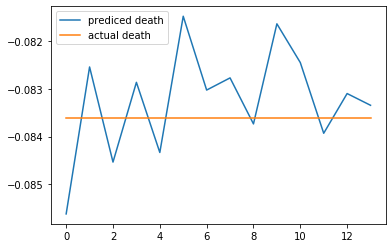

In [31]:
prediction_train = model_qntl[4].predict(X_train)

i=61
plt.plot(range(14), prediction_train[i,:])
plt.plot(range(14), y_train[i,:])
plt.legend(['prediced death', 'actual death'])
plt.show()

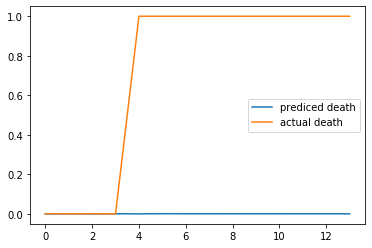

In [39]:
prediction_val = model_qntl[4].predict(X_val)

i=100
plt.plot(range(14), scaler.scale_[target_idx]*prediction_val[i,:]+scaler.mean_[target_idx])
plt.plot(range(14), scaler.scale_[target_idx]*y_val[i,:]+scaler.mean_[target_idx])
plt.legend(['prediced death', 'actual death'])
plt.show()

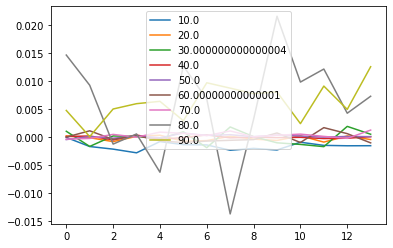

In [49]:
X_future = []

for data in dataList_norm:
    X_future.append(data[-history_size:, :])

X_future = np.asarray(X_future)

prediction_future = []
for i in range(len(model_qntl)):
    fips = 100
    prediction_future.append(scaler.scale_[target_idx]*model_qntl[i].predict(X_future)+scaler.mean_[target_idx])
prediction_future = np.asarray(prediction_future)

i = 100
for quantile in range(len(model_qntl)):
    plt.plot(range(14), prediction_future[quantile,i,:])

plt.legend((100*quantileList).tolist())
plt.show()

In [51]:
df_future = []
for i, fips in enumerate(FIPS_cluster[0]):
    for j in range(14):
        df_future.append([date_ed+pd.Timedelta(days=1+j), fips]+prediction_future[:,i,j].tolist())

df_future = pd.DataFrame(df_future, columns=['date', 'fips']+list(range(10, 100, 10)))
df_future.head()

,date,fips,10,20,30,40,50,60,70,80,90
0,2020-05-02,06049,0.000030,-0.000384,0.001150,0.000161,-0.000401,0.000337,-0.000401,0.001888,0.005650
1,2020-05-03,06049,-0.001836,-0.000065,-0.001531,-0.000617,0.001470,0.000739,0.001318,0.000498,0.000053
2,2020-05-04,06049,-0.002350,-0.000489,0.000057,0.000364,-0.000868,-0.000112,0.004175,0.001860,0.004694
3,2020-05-05,06049,-0.002669,-0.000372,-0.000017,-0.000366,-0.000833,-0.000051,0.000732,0.000656,0.005503
4,2020-05-06,06049,-0.000776,-0.000211,-0.000364,-0.000027,-0.002889,-0.000196,-0.000287,0.001239,0.006435


-----------------------------Train------------------------------------------

In [55]:
from datetime import datetime

history_size = 14
target_size = 14
val_size = 14
step_size = 1
target_idx = (columns_demo+columns_mt+columns_mb).index('deaths')
CELLS_ON_LAYER = 128
EVALUATION_INTERVAL = 200
EPOCHS = 10
lr = 0.001
quantileList = np.array(range(1, 10, 1)) * 0.1

for c in range(len(FIPS_cluster)):
    dataList = []
    for fips in FIPS_cluster[c]:
        data1 = kNNdata[kNNdata['fips']==fips][columns_demo].to_numpy()
        data1 = np.repeat(data1, len(date_win), axis=0)
        
        data2 = deaths[(deaths['fips']==fips) & (deaths['date'].isin(date_win))][['date']+columns_mt]
        _ = [[dt, 0, 0] for dt in date_win if dt not in list(data2['date'])]
        data2 = data2.append(pd.DataFrame(_, columns=['date']+columns_mt))
        data2 = data2.sort_values(by=['date'])[columns_mt].to_numpy()
        
        data3 = mobility[(mobility['fips']==fips) & (mobility['date'].isin(date_win))][['date']+columns_mb]
        data3 = data3.sort_values(by=['date'])[columns_mb].to_numpy()

        dataList.append(np.hstack((data1, data2, data3)))

    scaler = StandardScaler()
    scaler.fit(np.vstack(dataList).astype(np.float32))

    dataList_norm = []
    for i in range(len(dataList)):
        dataList_norm.append(scaler.transform(dataList[i]))

    X_train = []
    y_train = []
    X_val = []
    y_val = []
    X_future = []

    for data in dataList_norm:
        X_future.append(data[-history_size:, :])

        for i in range(history_size, len(data)-val_size-target_size, step_size):
            X_train.append(data[i-history_size:i, :] )
            y_train.append(data[i:i+target_size, target_idx])
        
        for i in range(len(data)-val_size, len(data)-target_size+1, step_size):
            X_val.append(data[i-history_size:i, :])
            y_val.append(data[i:i+target_size, target_idx])

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    X_val = np.asarray(X_val)
    y_val = np.asarray(y_val)
    X_future = np.asarray(X_future)

    BATCH_SIZE = 64 #256
    BUFFER_SIZE = 10000

    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_data = val_data.batch(BATCH_SIZE).repeat()

    model_qntl = []
    history_qntl = []
    for quantile in quantileList:
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(CELLS_ON_LAYER, return_sequences=True, input_shape=(train_data.element_spec[0].shape[1], train_data.element_spec[0].shape[2])))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.LSTM(round(CELLS_ON_LAYER/2), activation='relu',  return_sequences=True))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.LSTM(round(CELLS_ON_LAYER/4), activation='relu'))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(train_data.element_spec[1].shape[1]))

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        multi_step_model.compile(optimizer=optimizer, loss=lambda y_p, y: quantileLoss(quantile, y_p, y))
        multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=50)
        model_qntl.append(multi_step_model)
        history_qntl.append(multi_step_history)

    prediction_future = []
    for i in range(len(model_qntl)):
        prediction_future.append(scaler.scale_[target_idx]*model_qntl[i].predict(X_future)+scaler.mean_[target_idx])
    prediction_future = np.asarray(prediction_future)

    df_future = []
    for i, fips in enumerate(FIPS_cluster[c]):
        for j in range(14):
            df_future.append([date_ed+pd.Timedelta(days=1+j), fips]+prediction_future[:,i,j].tolist())

    df_future = pd.DataFrame(df_future, columns=['date', 'fips']+list(range(10, 100, 10)))

    mdhm = datetime.now().strftime('%m%d') + '_' + datetime.now().strftime('%H%M')
    df_future.to_csv(f'{homedir}/JK/prediction/LSTM_class={c}_{mdhm}.csv', index=False)

ss: 0.0499 - val_loss: 0.3292
Epoch 3/10
200/200 [==============================] - 11s 54ms/step - loss: 0.0460 - val_loss: 0.1871
Epoch 4/10
200/200 [==============================] - 11s 54ms/step - loss: 0.0475 - val_loss: 0.2270
Epoch 5/10
200/200 [==============================] - 11s 54ms/step - loss: 0.0396 - val_loss: 0.2131
Epoch 6/10
200/200 [==============================] - 11s 54ms/step - loss: 0.0418 - val_loss: 0.1807
Epoch 7/10
200/200 [==============================] - 11s 54ms/step - loss: 0.0344 - val_loss: 0.1675
Epoch 8/10
200/200 [==============================] - 11s 54ms/step - loss: 0.0312 - val_loss: 0.1740
Epoch 9/10
200/200 [==============================] - 11s 54ms/step - loss: 0.0340 - val_loss: 0.1884
Epoch 10/10
200/200 [==============================] - 11s 54ms/step - loss: 0.0290 - val_loss: 0.1730
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 16s 78ms/step - loss: 0.0905 - val_loss: 0.0594
Epoch 2/

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 0 and the array at index 1 has size 62

In [17]:
import pandas as pd
str(pd.Timestamp('2020-04-06'))[:10]

'2020-04-06'

In [40]:
from LSTM import TRAIN_SPLIT
history_size = 14
target_size = 14
total_size = 1000
# TRAIN_SPLIT = KFoldSplit(len(date_win), history_size, target_size, split_ratio=0.1) # len(date)-val_size

TRAIN_SPLIT = TRAIN_SPLIT(history_size, target_size, total_size, split_ratio=0.2)+1
print(len(range(history_size, TRAIN_SPLIT)), len(range(TRAIN_SPLIT+history_size, total_size-target_size+1)))

767 192


In [ ]:
)